# Climate U-Net Analysis

This notebook verifies the Fortran CUDA U-Net implementation against PyTorch and visualizes predictions.

## Goals:
1. Load trained weights from Fortran export
2. Verify PyTorch produces identical outputs
3. Visualize sample predictions
4. Analyze per-channel errors

In [1]:
import sys
sys.path.insert(0, '../inference')

import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path

from climate_unet import ClimateUNet, load_fortran_weights, load_sample_io

# Configuration - paths relative to notebook location
# Weights are saved in the climate data directory during training
CLIMATE_DATA_DIR = Path('../../v28d_streaming/datasets/climate/saved_models/climate_unet/')

# For verification: use debug_weights (exported BEFORE first backward pass)
# These weights match the sample_0000 I/O that was exported at the same time
WEIGHTS_DIR = CLIMATE_DATA_DIR / 'debug_weights'  # For verification (matches sample I/O)
# WEIGHTS_DIR = CLIMATE_DATA_DIR / 'epoch_0004'  # Best trained checkpoint

SAMPLES_DIR = CLIMATE_DATA_DIR  # Sample I/O files are in the parent directory

CHANNEL_NAMES = ['u10 (E-W wind)', 'v10 (N-S wind)', 't2m (Temperature)', 
                 'sp (Surface Pressure)', 'msl (Sea Level Pressure)', 'tp (Precipitation)']

print(f'Looking for weights in: {WEIGHTS_DIR.resolve()}')
print(f'Looking for samples in: {SAMPLES_DIR.resolve()}')

Looking for weights in: /var/home/fraser/Downloads/CIFAR-10/v28d_streaming/datasets/climate/saved_models/climate_unet/debug_weights
Looking for samples in: /var/home/fraser/Downloads/CIFAR-10/v28d_streaming/datasets/climate/saved_models/climate_unet


## 1. Load Model and Weights

In [2]:
# Create model
model = ClimateUNet()
print(f"Model parameters: {model.count_parameters():,}")

# Load Fortran weights if available
if WEIGHTS_DIR.exists():
    load_fortran_weights(model, WEIGHTS_DIR)
    model.eval()
    print("Weights loaded successfully!")
else:
    print(f"WARNING: Weights directory not found: {WEIGHTS_DIR}")
    print("Run training with --save --export_samples first.")

Model parameters: 1,947,910
Loading weights from ../../v28d_streaming/datasets/climate/saved_models/climate_unet/debug_weights
  Loaded enc1_conv1: weight torch.Size([32, 6, 3, 3]), bias (32,)
  Loaded enc1_conv2: weight torch.Size([32, 32, 3, 3]), bias (32,)
  Loaded enc2_conv1: weight torch.Size([64, 32, 3, 3]), bias (64,)
  Loaded enc2_conv2: weight torch.Size([64, 64, 3, 3]), bias (64,)
  Loaded enc3_conv1: weight torch.Size([128, 64, 3, 3]), bias (128,)
  Loaded enc3_conv2: weight torch.Size([128, 128, 3, 3]), bias (128,)
  Loaded bottleneck1: weight torch.Size([256, 128, 3, 3]), bias (256,)
  Loaded bottleneck2: weight torch.Size([256, 256, 3, 3]), bias (256,)
  Loaded dec3_conv1: weight torch.Size([128, 384, 3, 3]), bias (128,)
  Loaded dec3_conv2: weight torch.Size([128, 128, 3, 3]), bias (128,)
  Loaded dec2_conv1: weight torch.Size([64, 192, 3, 3]), bias (64,)
  Loaded dec2_conv2: weight torch.Size([64, 64, 3, 3]), bias (64,)
  Loaded dec1_conv1: weight torch.Size([32, 96, 3,

## 2. Verify Fortran vs PyTorch Outputs

In [3]:
# Load sample I/O from Fortran
# Note: Sample files are in SAMPLES_DIR (parent), weights in WEIGHTS_DIR (epoch subfolder)
try:
    fortran_input, fortran_output = load_sample_io(SAMPLES_DIR, sample_id=0)
    print(f"Fortran input shape:  {fortran_input.shape}")
    print(f"Fortran output shape: {fortran_output.shape}")
    
    # Run PyTorch inference
    with torch.no_grad():
        pytorch_output = model(fortran_input)
    print(f"PyTorch output shape: {pytorch_output.shape}")
    
    # Compare
    diff = torch.abs(fortran_output - pytorch_output)
    print(f"\nMax difference: {diff.max().item():.6e}")
    print(f"Mean difference: {diff.mean().item():.6e}")
    
    if diff.max().item() < 1e-4:
        print("\nVERIFICATION PASSED: Outputs match!")
    else:
        print("\nWARNING: Differences detected - investigate further")
        
except FileNotFoundError as e:
    print(f"Sample files not found. Run training with --export_samples")
    fortran_input = None
    fortran_output = None
    pytorch_output = None

Fortran input shape:  torch.Size([1, 6, 240, 121])
Fortran output shape: torch.Size([1, 6, 240, 121])
PyTorch output shape: torch.Size([1, 6, 240, 121])

Max difference: 2.831221e-07
Mean difference: 1.895799e-08

VERIFICATION PASSED: Outputs match!


## 3. Visualize Sample Prediction

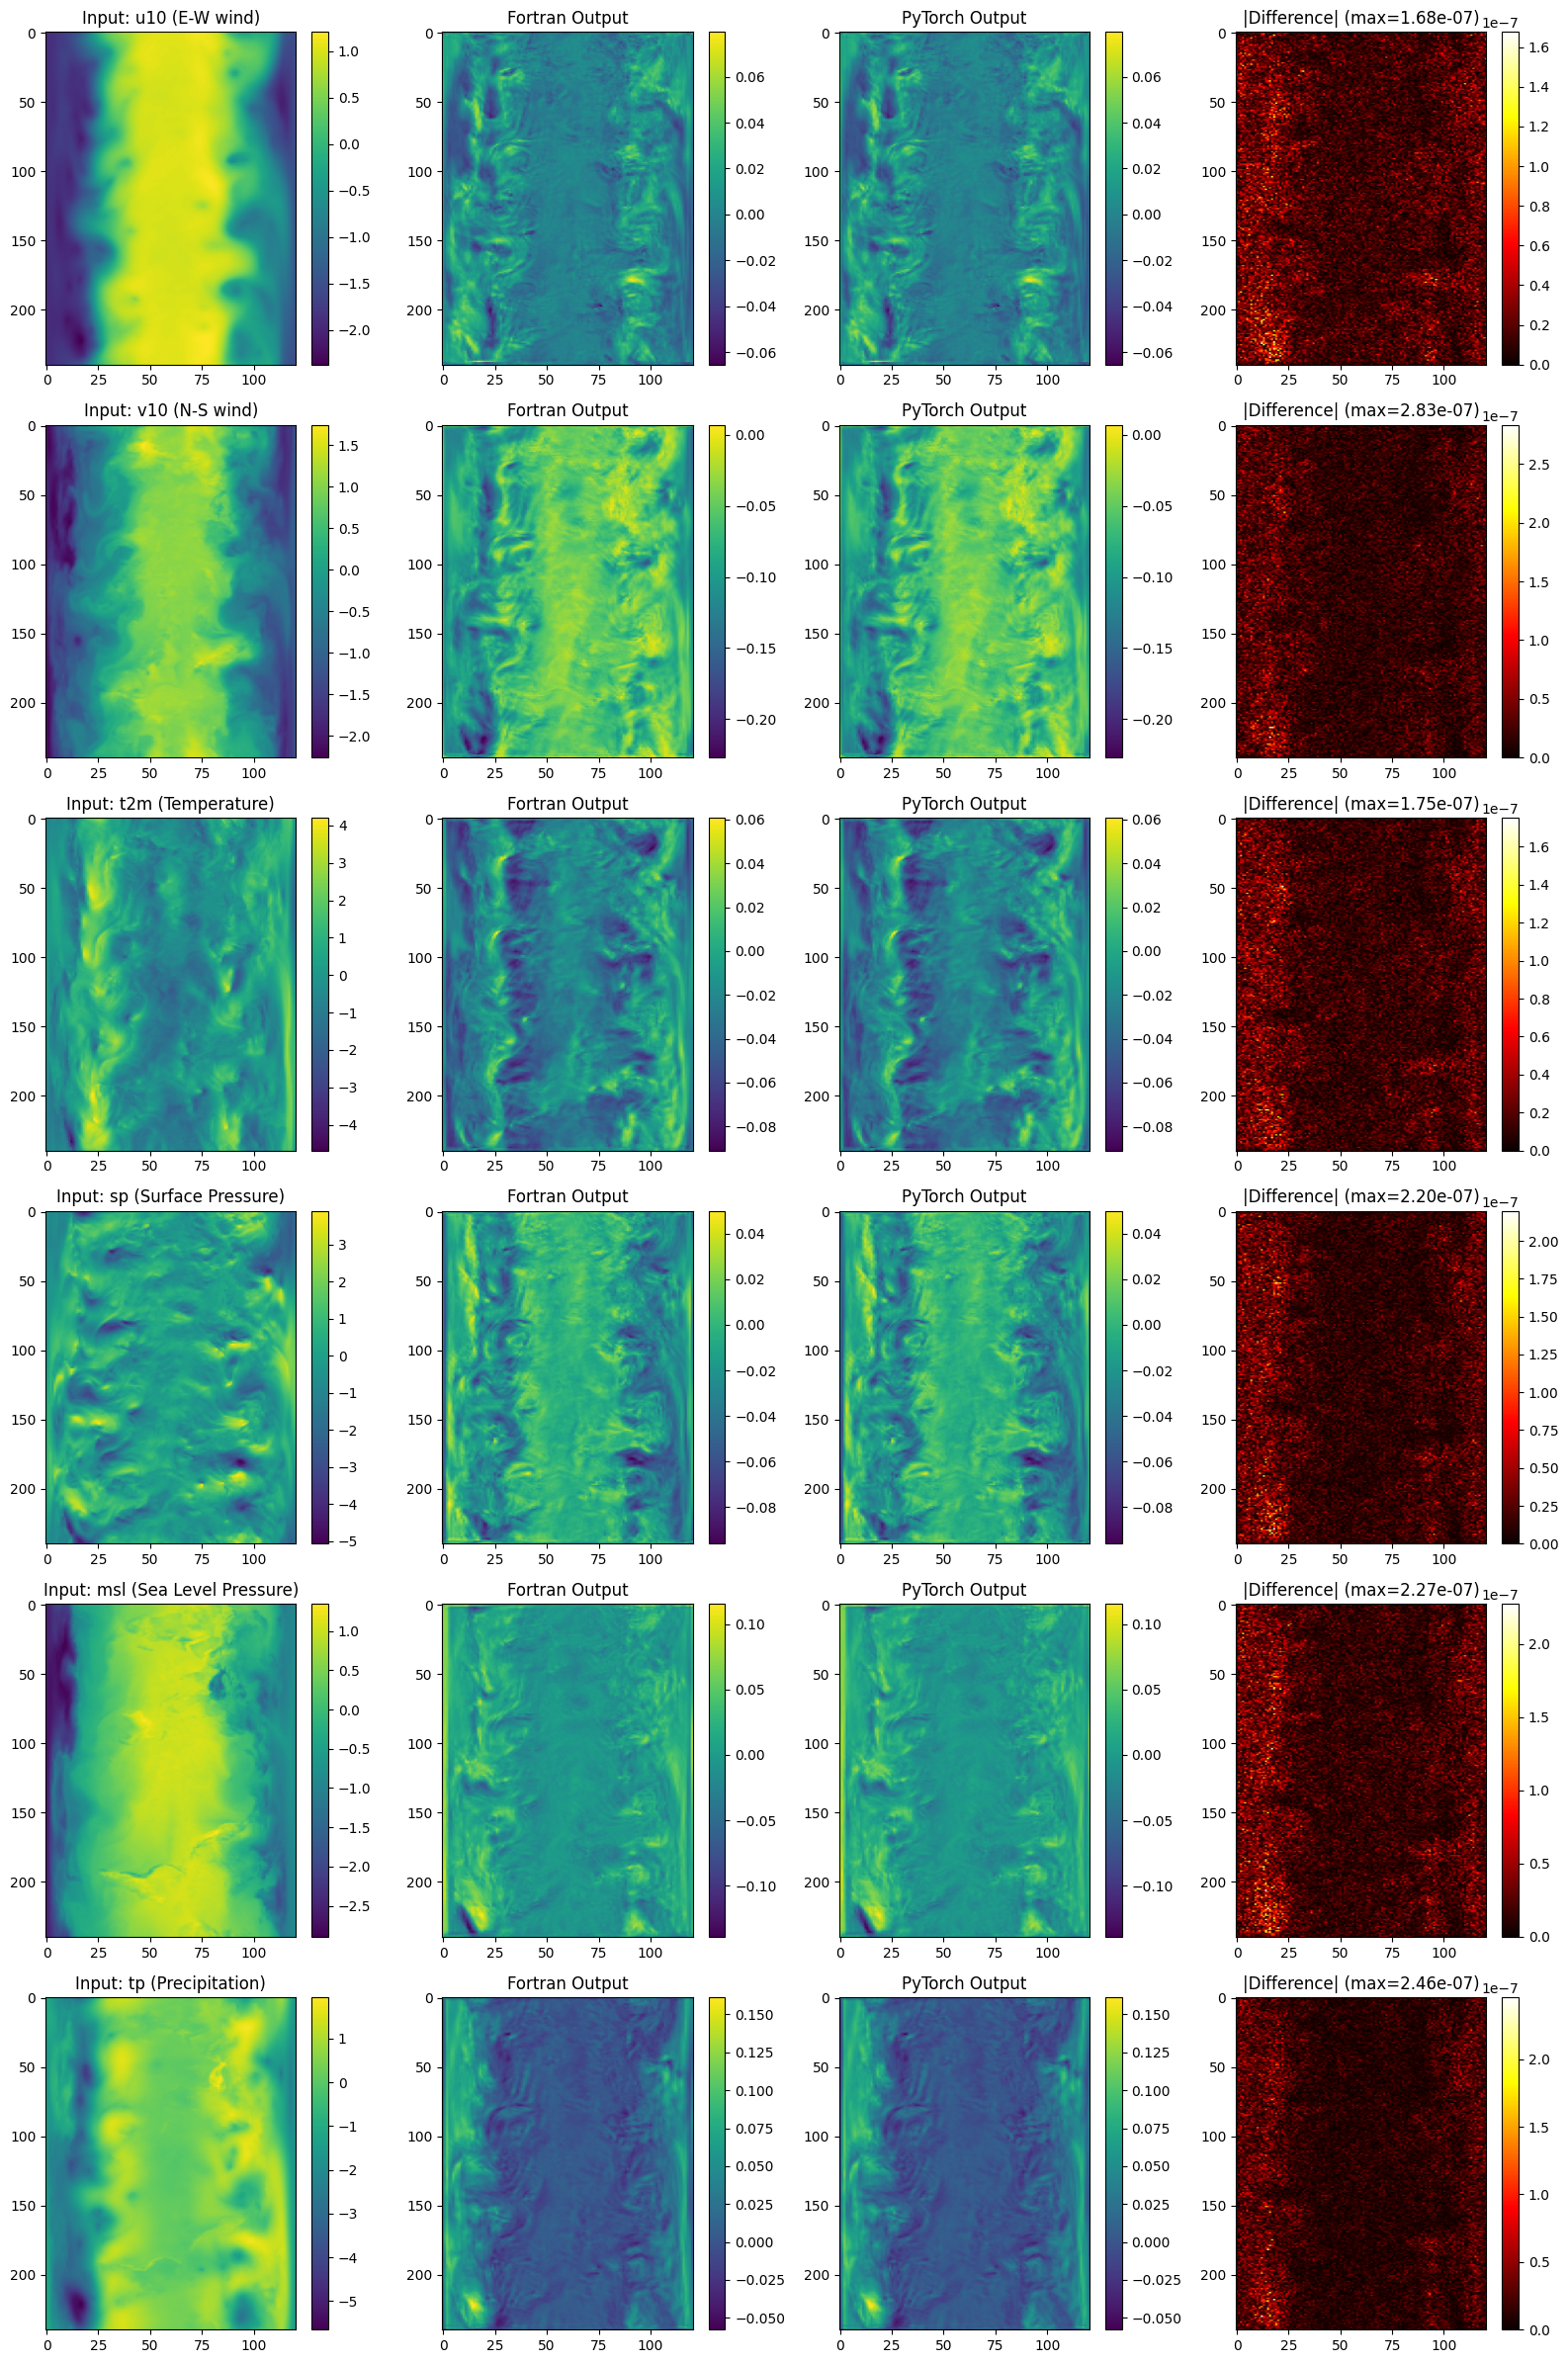

In [4]:
if fortran_input is not None:
    # Get numpy arrays
    inp = fortran_input[0].numpy()  # (6, 240, 121)
    out_fortran = fortran_output[0].numpy()
    out_pytorch = pytorch_output[0].numpy()
    
    # Plot each channel
    fig, axes = plt.subplots(6, 4, figsize=(16, 24))
    
    for c in range(6):
        # Input (t)
        im0 = axes[c, 0].imshow(inp[c], aspect='auto', cmap='viridis')
        axes[c, 0].set_title(f'Input: {CHANNEL_NAMES[c]}')
        plt.colorbar(im0, ax=axes[c, 0])
        
        # Fortran Output (t+6h prediction)
        im1 = axes[c, 1].imshow(out_fortran[c], aspect='auto', cmap='viridis')
        axes[c, 1].set_title(f'Fortran Output')
        plt.colorbar(im1, ax=axes[c, 1])
        
        # PyTorch Output
        im2 = axes[c, 2].imshow(out_pytorch[c], aspect='auto', cmap='viridis')
        axes[c, 2].set_title(f'PyTorch Output')
        plt.colorbar(im2, ax=axes[c, 2])
        
        # Difference
        diff_c = np.abs(out_fortran[c] - out_pytorch[c])
        im3 = axes[c, 3].imshow(diff_c, aspect='auto', cmap='hot')
        axes[c, 3].set_title(f'|Difference| (max={diff_c.max():.2e})')
        plt.colorbar(im3, ax=axes[c, 3])
    
    plt.tight_layout()
    plt.savefig('verification_comparison.png', dpi=150)
    plt.show()
else:
    print("No sample data available for visualization")

## 4. Load Raw Climate Data for Additional Analysis

In [5]:
# Path to streaming data
DATA_DIR = Path('../../v28d_streaming/datasets/climate/climate_data_streaming/')

def load_streaming_sample(data_dir, sample_idx=0):
    """Load a single sample from streaming binary files"""
    input_file = data_dir / 'inputs_train_stream.bin'
    output_file = data_dir / 'outputs_train_stream.bin'
    
    features = 6 * 240 * 121  # 174240 features per sample
    
    # Read single sample
    with open(input_file, 'rb') as f:
        f.seek(sample_idx * features * 4)  # 4 bytes per float32
        inp = np.fromfile(f, dtype=np.float32, count=features)
    
    with open(output_file, 'rb') as f:
        f.seek(sample_idx * features * 4)
        out = np.fromfile(f, dtype=np.float32, count=features)
    
    # Reshape to (6, 240, 121) - C-major order (channel varies slowest)
    inp = inp.reshape((6, 240, 121))
    out = out.reshape((6, 240, 121))
    
    return inp, out

if DATA_DIR.exists():
    sample_input, sample_target = load_streaming_sample(DATA_DIR, sample_idx=0)
    print(f"Sample input shape: {sample_input.shape}")
    print(f"Sample target shape: {sample_target.shape}")
    
    # Statistics
    print("\nInput statistics per channel:")
    for c in range(6):
        print(f"  {CHANNEL_NAMES[c]}: mean={sample_input[c].mean():.3f}, std={sample_input[c].std():.3f}")
else:
    print(f"Data directory not found: {DATA_DIR}")

Sample input shape: (6, 240, 121)
Sample target shape: (6, 240, 121)

Input statistics per channel:
  u10 (E-W wind): mean=-0.067, std=0.948
  v10 (N-S wind): mean=-0.094, std=0.991
  t2m (Temperature): mean=-0.064, std=1.033
  sp (Surface Pressure): mean=-0.018, std=1.043
  msl (Sea Level Pressure): mean=-0.101, std=0.948
  tp (Precipitation): mean=0.059, std=0.966


## 5. Compare Prediction to Ground Truth

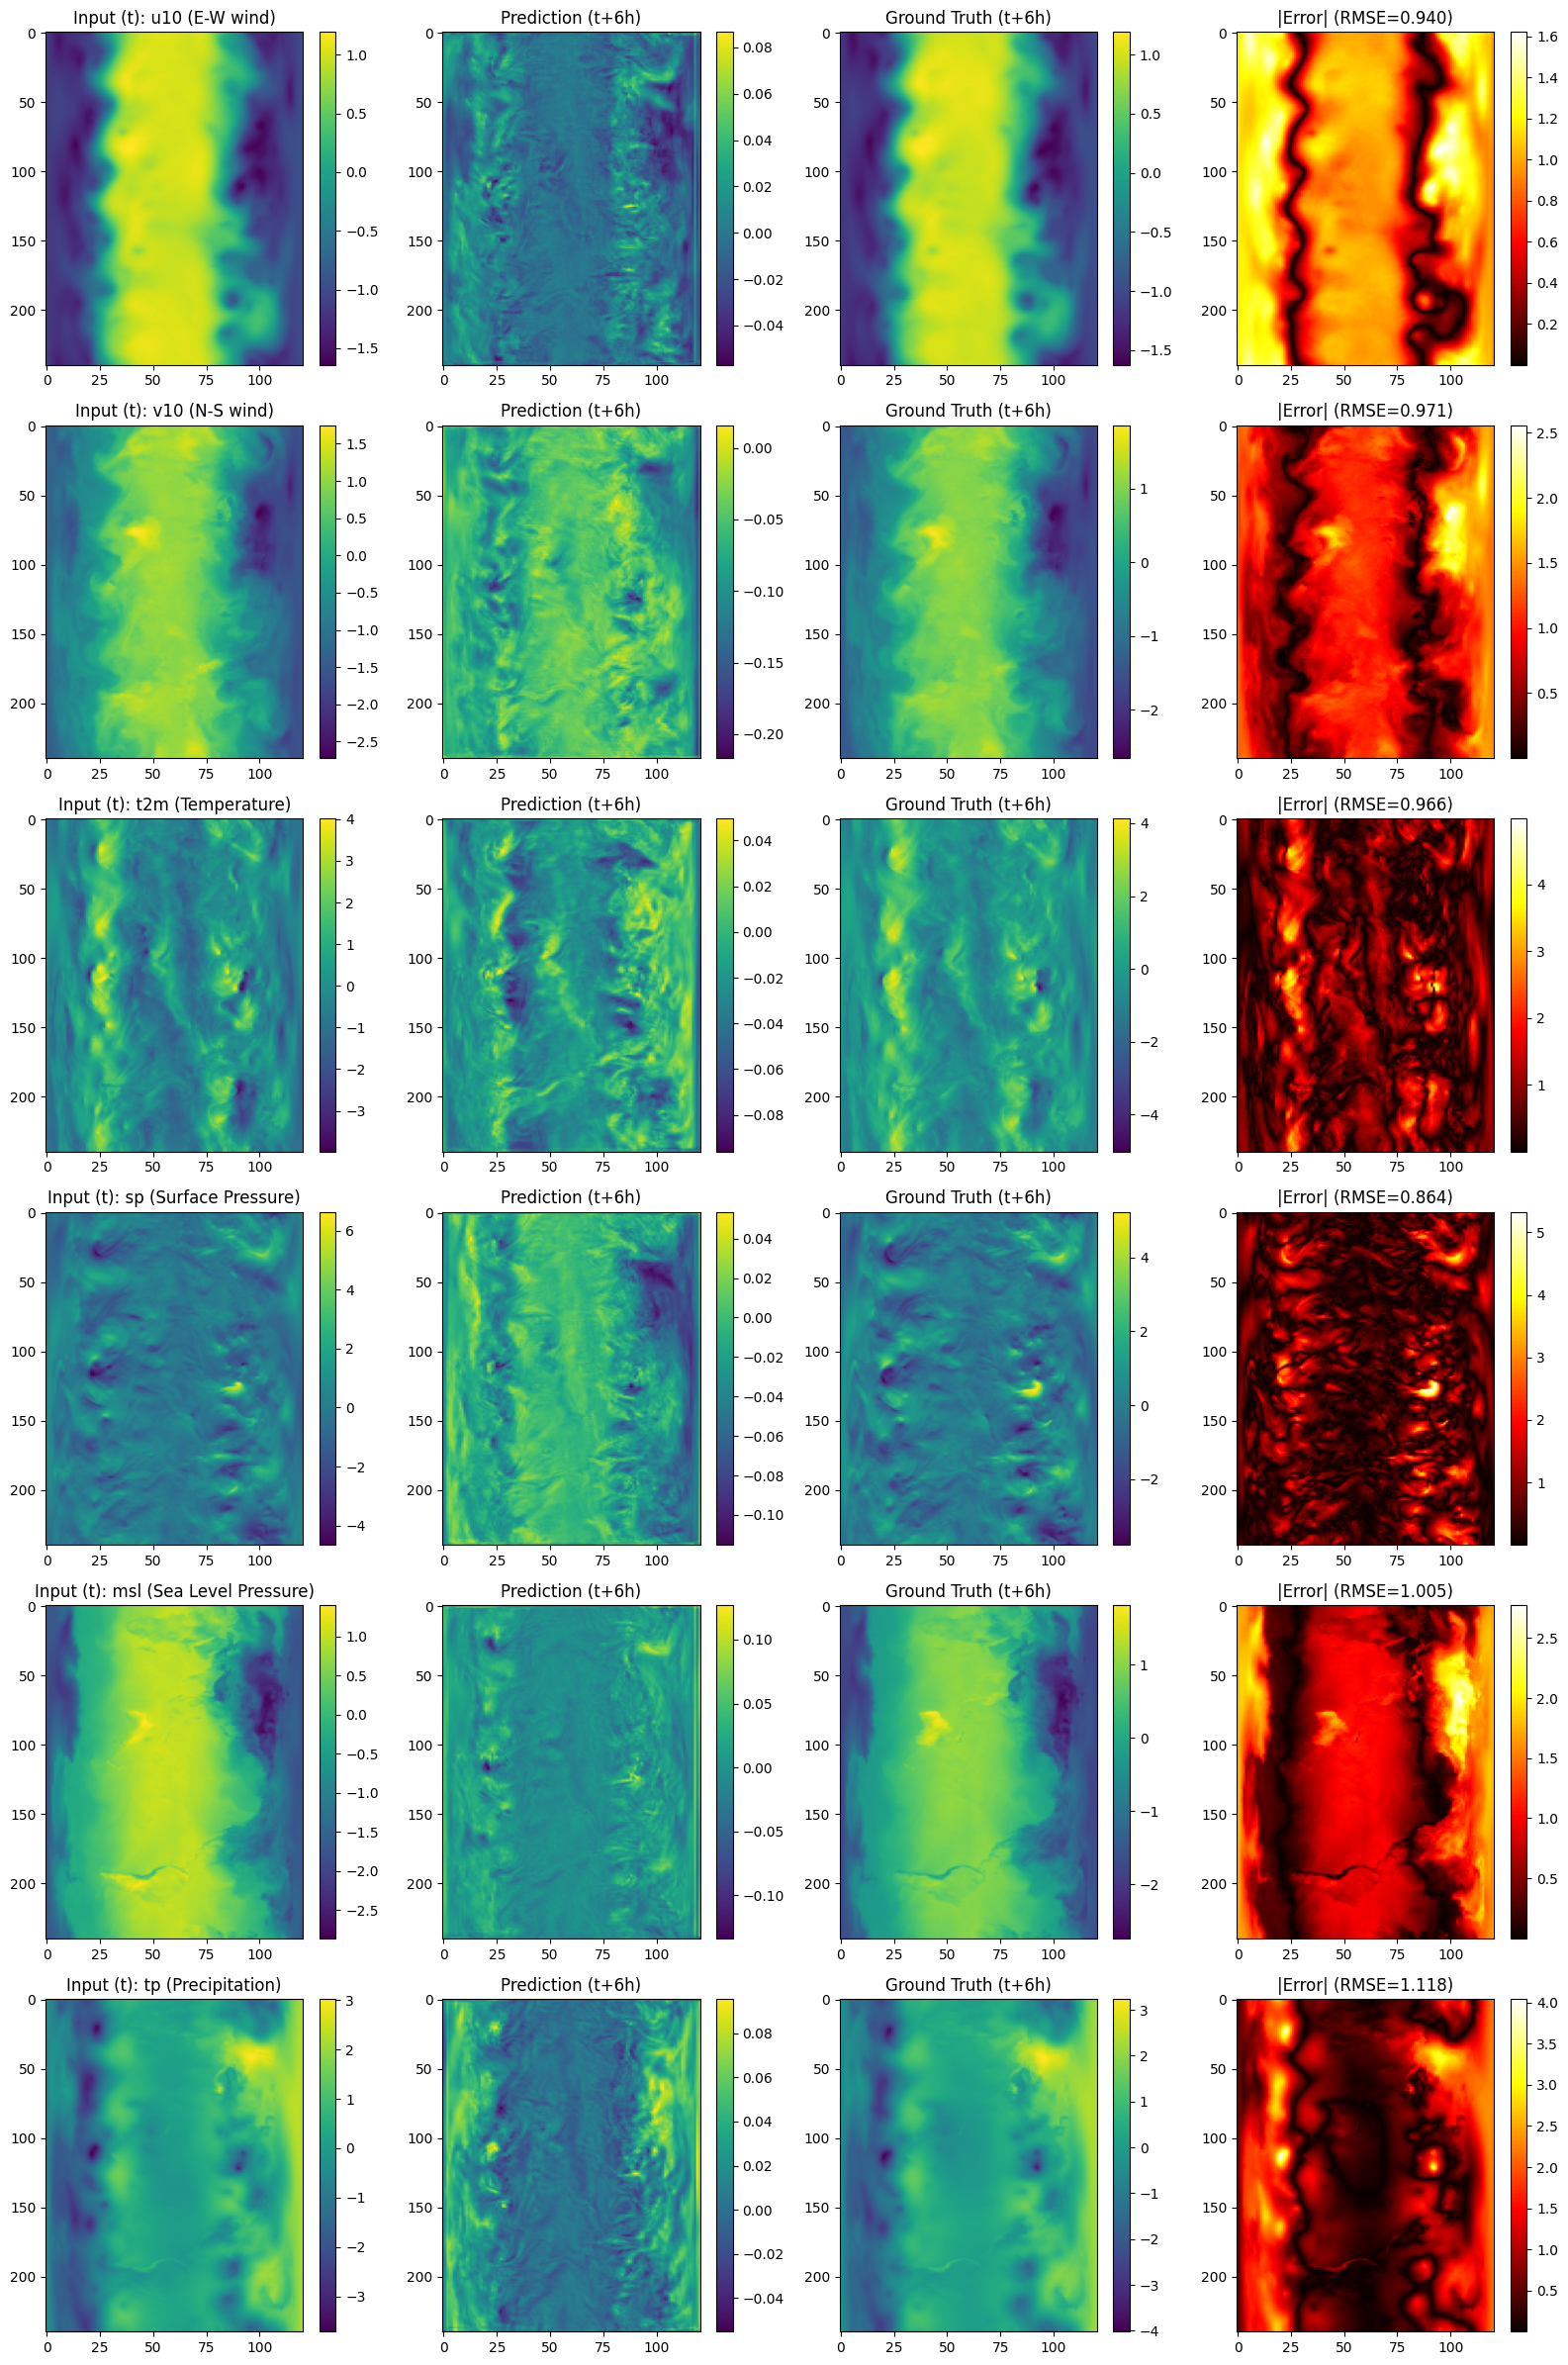


Overall MSE: 0.961262
Overall RMSE: 0.980440


In [6]:
if DATA_DIR.exists() and WEIGHTS_DIR.exists():
    # Load a sample and run inference
    sample_input, sample_target = load_streaming_sample(DATA_DIR, sample_idx=100)
    
    # Convert to tensor and add batch dimension
    inp_tensor = torch.from_numpy(sample_input).unsqueeze(0)  # (1, 6, 240, 121)
    
    # Run inference
    with torch.no_grad():
        prediction = model(inp_tensor)
    
    pred = prediction[0].numpy()  # (6, 240, 121)
    
    # Plot: Input -> Prediction -> Target -> Error
    fig, axes = plt.subplots(6, 4, figsize=(16, 24))
    
    for c in range(6):
        # Input
        im0 = axes[c, 0].imshow(sample_input[c], aspect='auto', cmap='viridis')
        axes[c, 0].set_title(f'Input (t): {CHANNEL_NAMES[c]}')
        plt.colorbar(im0, ax=axes[c, 0])
        
        # Prediction
        im1 = axes[c, 1].imshow(pred[c], aspect='auto', cmap='viridis')
        axes[c, 1].set_title(f'Prediction (t+6h)')
        plt.colorbar(im1, ax=axes[c, 1])
        
        # Ground Truth
        im2 = axes[c, 2].imshow(sample_target[c], aspect='auto', cmap='viridis')
        axes[c, 2].set_title(f'Ground Truth (t+6h)')
        plt.colorbar(im2, ax=axes[c, 2])
        
        # Error
        error = np.abs(pred[c] - sample_target[c])
        im3 = axes[c, 3].imshow(error, aspect='auto', cmap='hot')
        axes[c, 3].set_title(f'|Error| (RMSE={np.sqrt(np.mean(error**2)):.3f})')
        plt.colorbar(im3, ax=axes[c, 3])
    
    plt.tight_layout()
    plt.savefig('prediction_analysis.png', dpi=150)
    plt.show()
    
    # Overall metrics
    mse = np.mean((pred - sample_target)**2)
    rmse = np.sqrt(mse)
    print(f"\nOverall MSE: {mse:.6f}")
    print(f"Overall RMSE: {rmse:.6f}")
else:
    print("Data or weights not available")

## 6. Summary

This notebook demonstrates:
1. **Correctness verification**: PyTorch outputs match Fortran CUDA outputs
2. **Visual inspection**: Predictions look reasonable for weather data
3. **Error analysis**: Per-channel RMSE shows which variables are harder to predict

Next steps:
- Train longer with learning rate scheduling
- Add BatchNorm for stability
- Evaluate on full test set